## Import dependencies

In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sn
import scipy as sp
from tqdm import tqdm
import glob

from fair import *
from fair.scripts.data_retrieval import *

%matplotlib inline

definition used to round output tables to given sig figs.

In [2]:
def round_to_sf(x,sf):
    if x==0:
        return 0
    if np.isnan(x):
        return '-'
    else:
        num= round(x, sf - int(np.floor(np.log10(abs(x)))))
        if abs(num)>10**sf:
            return str(int(num))
        else:
            return str(num)

# I. Default parameter simulated concentrations
Here we run historical emissions to test how the default parameter set simulates the historical evolution of concentrations.

In [3]:
## first we view & create a latex table for the default parameter set:
default_params = get_gas_parameter_defaults()
params_table = default_params.default.T.sort_index().rename(dict(a1='$a_1$',a2='$a_2$',a3='$a_3$',a4='$a_4$',
                                                                  tau1='$\tau_1$',tau2='$\tau_2$',tau3='$\tau_3$',tau4='$\tau_4$',
                                                                  r0='$r_0$',rC='$r_u$',rT='$r_T$',rA='$r_a$',PI_conc='PI\_conc',
                                                                  f1='$f_1$',f2='$f_2$',f3='$f_3$'),axis=1)
params_table.index.name='agent'
params_table.columns.name='parameter'
params_table.index = [x.replace('_','\_') for x in params_table.index]

params_table.applymap(lambda x:round_to_sf(x,2)).replace(np.nan,'')#.to_latex('../../docs/manuscript/tables/TabS2',escape=False,bold_rows=True)

parameter,$a_1$,$a_2$,$a_3$,$a_4$,$\tau_1$,$\tau_2$,$\tau_3$,$\tau_4$,$r_0$,$r_u$,$r_T$,$r_a$,PI\_conc,emis2conc,$f_1$,$f_2$,$f_3$
bc,1.0,0,0,0,1.0,1.0,1.0,1.0,1.0,0,0,0,1e-15,1.0,0,0.0567,0
bc|aci,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,-0.00801,0
bc|bc\_on\_snow,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0.0116,0
c2f6,1.0,0,0,0,100.0,1.0,1.0,1.0,185,0,0,0,1e-15,0.0408,0,0.25,0
c3f8,1.0,0,0,0,26.0,1.0,1.0,1.0,133,0,0,0,1e-15,0.0299,0,0.28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oc|aci,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,-0.00801,0
sf6,1.0,0,0,0,32.0,1.0,1.0,1.0,151,0,0,0,1e-15,0.0385,0,0.57,0
so2,1.0,0,0,0,1.0,1.0,1.0,1.0,1.0,0,0,0,171,1.0,0,-0.00474,0
so2f2,1.0,0,0,0,0.36,1.0,1.0,1.0,2.02,0,0,0,1e-15,0.0551,0,0.2,0


### data retrieval

#### concentrations

WMGHG concentrations are from the CMIP6 concentration dataset, [Meinshausen et al., 2017](https://www.geosci-model-dev.net/10/2057/2017/). For some species, these are extended using data from NOAA.

Reference:

Meinshausen, M., Vogel, E., Nauels, A., Lorbacher, K., Meinshausen, N., Etheridge, D. M., … Weiss, R. (2017). Historical greenhouse gas concentrations for climate modelling (CMIP6). Geoscientific Model Development, 10(5), 2057–2116. https://doi.org/10.5194/gmd-10-2057-2017

In [4]:
import ftplib

## import concentrations from official CMIP6 timeseries:
CMIP6_conc_ftp = ftplib.FTP('data.iac.ethz.ch','anonymous')
CMIP6_conc_ftp.cwd('CMIP6/input4MIPs/UoM/GHGConc/CMIP/yr/atmos/UoM-CMIP-1-1-0/GHGConc/gr3-GMNHSH/v20160701')
CMIP6_ftp_list = [x for x in CMIP6_conc_ftp.nlst() if x[-3:]=='csv']
WMGHG_concs = pd.DataFrame(dict(zip(['_'.join(x.split('_')[3:-8]) for x in CMIP6_ftp_list],[pd.read_csv('ftp://data.iac.ethz.ch/CMIP6/input4MIPs/UoM/GHGConc/CMIP/yr/atmos/UoM-CMIP-1-1-0/GHGConc/gr3-GMNHSH/v20160701/'+x,usecols=[0,1],index_col=0).iloc[:,0] for x in CMIP6_ftp_list])))
WMGHG_concs = WMGHG_concs[[x for x in WMGHG_concs.columns if x[-2:]!='eq']] # remove "equivalent" concentrations

WMGHG_concs['halon1202'] = 0
WMGHG_concs.loc[1765:2014,'halon1202'] = pd.read_csv('http://www.pik-potsdam.de/~mmalte/rcps/data/RCP45_MIDYEAR_CONCENTRATIONS.DAT',skiprows=38,delim_whitespace=True,index_col=0)['HALON1202'].loc[1765:2014].values

In [5]:
## we extend CO2, CH4 & N2O out to 2019 using the NOAA ESRL data
NOAA_molefrac = pd.read_csv('https://www.esrl.noaa.gov/gmd/aggi/NOAA_MoleFractions_2020.csv',skiprows=2,index_col=0,skipfooter=5).iloc[1:].replace('nd',np.nan).apply(pd.to_numeric).rename(dict(CO2='carbon_dioxide',CH4='methane',N2O='nitrous_oxide'),axis=1)

WMGHG_concs = WMGHG_concs.reindex(np.arange(2020))

for species in ['carbon_dioxide','methane','nitrous_oxide']:
    
    # scale the NOAA data to join seamlessly (scale factors are almost exactly 1)
    scale_factor = WMGHG_concs.loc[2010:2014,species].mean() / NOAA_molefrac.loc[2010:2015,species].mean()
    WMGHG_concs.loc[2015:2019,species] = NOAA_molefrac.loc[2015:2020,species].values * scale_factor

/nfs/a65/pmcjs/miniconda3/envs/leach2021/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


In [6]:
WMGHG_concs.drop(np.arange(1750),inplace=True)

In [7]:
# rescale all GHGs to be in ppb (bar CO2)
WMGHG_concs[WMGHG_concs.columns.drop(['carbon_dioxide','methane','nitrous_oxide'])] *= 1/1000

#### emissions & forcing

Emissions & external forcing are taken from the RCMIP protocol.

Reference:

Nicholls, Z. R. J., Meinshausen, M., Lewis, J., Gieseke, R., Dommenget, D., Dorheim, K., … Xie, Z. (2020). Reduced complexity model intercomparison project phase 1: Protocol, results and initial observations. Geoscientific Model Development Discussions, 1–33. https://doi.org/10.5194/gmd-2019-375

In [8]:
## emissions
def get_SSP_emms(ssp):
    emms = RCMIP_to_FaIR_input_emms(ssp).interpolate().loc[1750:2100]
    rebase_species = ['so2','nox','co','nmvoc','bc','nh3','oc','nox_avi','methyl_bromide','methyl_chloride','chcl3','ch2cl2']
    emms.loc[:,rebase_species] -= emms.loc[1750,rebase_species]
    return emms

choose_ssps=['ssp119','ssp126','ssp245','ssp370','ssp585']
SSP_emms = pd.concat([get_SSP_emms(x) for x in choose_ssps],axis=1,keys=choose_ssps)

In [9]:
## forcing
SSP_forc = pd.concat([get_RCMIP_forc(x) for x in choose_ssps],axis=1,keys=choose_ssps).loc[:2100]

## run the model!

In [10]:
default_SSP_run = run_FaIR(emissions_in=SSP_emms,forcing_in=SSP_forc)

Integrating 5 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|o3', 'cfc114', 'cfc114|o3', 'cfc115', 'cfc115|o3', 'cfc11|o3', 'cfc12', 'cfc12|o3', 'ch2cl2', 'ch2cl2|o3', 'ch3ccl3', 'ch3ccl3|o3', 'chcl3', 'chcl3|o3', 'co', 'co|o3', 'halon1202', 'halon1202|o3', 'halon1211', 'halon1211|o3', 'halon1301', 'halon1301|o3', 'halon2402', 'halon2402|o3', 'hcfc141b', 'hcfc141b|o3', 'hcfc142b', 'hcfc142b|o3', 'hcfc22', 'hcfc22|o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|o3', 'methyl_bromide', 'methyl_bromide|o3', 'methyl_chloride', 'methyl_chloride|o3', 'nf3', 'nh3', 'nitrous_oxide', 'nitrous_oxide|o3', 'nmvoc', 'nmvoc|o3', 'nox', 'nox_avi'

100%|██████████| 350/350 [00:00<00:00, 1786.61 timestep/s]


## plot the results

In [9]:
## get MAGICC7.1.0 data to benchmark
MAGICC_defaults = pd.read_csv('../../aux/input-data/RCMIP/data_results_phase-1_magicc7_rcmip_phase-1_magicc7.1.0.beta_v1-0-0.csv').drop(['Model','Unit','Climatemodel','Region'],axis=1).set_index(['Scenario','Variable']).reindex(['esm-'+x+'-allGHG' for x in choose_ssps],level=0)
RCMIP_outputmap = pd.read_csv('../../aux/FaIRv2.0.0-alpha_RCMIP_inputmap.csv',index_col=0)

MAGICC_defaults = MAGICC_defaults.rename(RCMIP_outputmap.reset_index().set_index('RCMIP_concs_key')['index'].to_dict(),level=1).reindex(RCMIP_outputmap.index,level=1).T
MAGICC_defaults.index = MAGICC_defaults.index.astype(int)
MAGICC_defaults.rename(dict(zip(['esm-'+x+'-allGHG' for x in choose_ssps],choose_ssps)),axis=1,level=0,inplace=True)

In [10]:
## get FaIRv1.5 data to benchmark
FaIR_defaults = pd.concat([pd.read_csv('../../aux/input-data/RCMIP/rcmip-master-data-results-phase-1-fair/data/results/phase-1/fair/rcmip_phase-1_fair-1.5-default-'+x+'_v1-0-1.csv') for x in ['esm-'+x+'-allGHG' for x in choose_ssps]]).drop(['Model','Unit','Climatemodel','Region'],axis=1).set_index(['Scenario','Variable'])

FaIR_defaults = FaIR_defaults.rename(RCMIP_outputmap.reset_index().set_index('RCMIP_concs_key')['index'].to_dict(),level=1).reindex(RCMIP_outputmap.index,level=1).T
FaIR_defaults.index = [int(x[:4]) for x in FaIR_defaults.index]
FaIR_defaults.rename(dict(zip(['esm-'+x+'-allGHG' for x in choose_ssps],choose_ssps)),axis=1,level=0,inplace=True)

In [11]:
## set plot rcParams
matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11

matplotlib.rcParams['axes.formatter.limits']=-3,3

matplotlib.rcParams['legend.frameon']=False

plt.rcParams['pdf.fonttype'] = 42

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


''

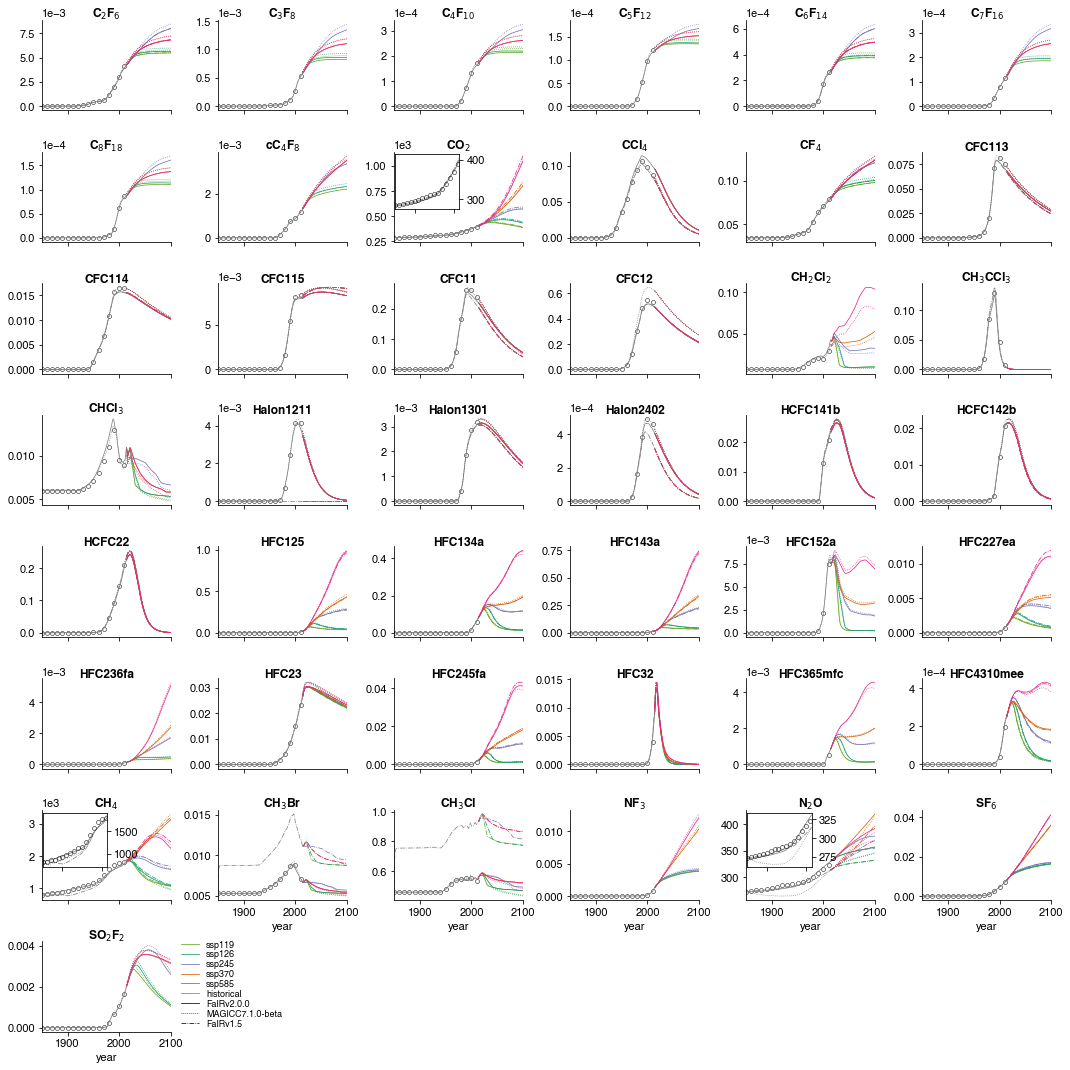

In [32]:
## & plot!
colors= {'ssp245':'#7570b3','ssp370':'#d95f02','ssp585':'#e7298a','ssp119':'#66a61e','ssp126':'#1b9e77','history':'grey'}
map_conc_names = dict(zip(WMGHG_concs.columns,['C$_2$F$_6$','C$_3$F$_8$','C$_4$F$_{10}$','C$_5$F$_{12}$','C$_6$F$_{14}$','C$_7$F$_{16}$','C$_8$F$_{18}$','cC$_4$F$_{8}$','CO$_2$','CCl$_4$','CF$_4$','CFC113','CFC114','CFC115','CFC11','CFC12','CH$_2$Cl$_2$','CH$_3$CCl$_3$','CHCl$_3$','Halon1211','Halon1301','Halon2402','HCFC141b', 'HCFC142b', 'HCFC22', 'HFC125','HFC134a', 'HFC143a', 'HFC152a', 'HFC227ea', 'HFC236fa', 'HFC23','HFC245fa', 'HFC32', 'HFC365mfc', 'HFC4310mee','CH$_4$','CH$_3$Br','CH$_3$Cl','NF$_3$','N$_2$O','SF$_6$','SO$_2$F$_2$','Halon1202']))

fig,ax = plt.subplots(8,6,figsize=(15,15))

with plt.rc_context({"lines.linewidth": 0.75,"lines.markersize":4,"lines.markerfacecolor":'none',"lines.markeredgewidth":0.5}):

    for i,gas in enumerate(WMGHG_concs.columns):
        
        ax.flatten()[i].plot(WMGHG_concs.loc[1850:,gas].iloc[::10],'o',color='k')
        
        for ssp in choose_ssps:
            ax.flatten()[i].plot(default_SSP_run['C'].loc[2014:2100,(ssp,'default',gas)],color=colors[ssp],label=ssp)

            ax.flatten()[i].plot(MAGICC_defaults.loc[2014:2100,(ssp,gas)]*RCMIP_outputmap.loc[gas,'RCMIP_concs_scaling'],color=colors[ssp],ls=':')
            
            try: # need exceptions for FaIR as not all gases were included as this point.
                ax.flatten()[i].plot(FaIR_defaults.loc[2014:2100,(ssp,gas)]*RCMIP_outputmap.loc[gas,'RCMIP_concs_scaling'],color=colors[ssp],ls='-.')
            except:
                pass

        ax.flatten()[i].plot(default_SSP_run['C'].loc[1850:2014,('ssp245','default',gas)],color=colors['history'],label='historical')
        
        ax.flatten()[i].plot(MAGICC_defaults.loc[1850:2014,(ssp,gas)]*RCMIP_outputmap.loc[gas,'RCMIP_concs_scaling'],color=colors['history'],ls=':')
        
        try:
            ax.flatten()[i].plot(FaIR_defaults.loc[1850:2014,(ssp,gas)]*RCMIP_outputmap.loc[gas,'RCMIP_concs_scaling'],color=colors['history'],ls='-.')
        except:
            pass
        
        ax.flatten()[i].text(0.5,0.98,map_conc_names[gas],transform=ax.flatten()[i].transAxes,va='bottom',ha='center',fontsize=12,fontweight='bold')
    
        if gas in ['carbon_dioxide','methane','nitrous_oxide']:
            ax1 = inset_axes(ax.flatten()[i],width="100%",height="100%",bbox_to_anchor=(0.05,0.43,0.5,0.6),bbox_transform=ax.flatten()[i].transAxes)
            ax1.plot(default_SSP_run['C'].loc[1850:2014,('ssp245','default',gas)],color=colors['history'])
            ax1.plot(MAGICC_defaults.loc[1850:2014,(ssp,gas)]*RCMIP_outputmap.loc[gas,'RCMIP_concs_scaling'],color=colors['history'],ls=':')
            ax1.plot(FaIR_defaults.loc[1850:2014,(ssp,gas)]*RCMIP_outputmap.loc[gas,'RCMIP_concs_scaling'],color=colors['history'],ls='-.')
            ax1.plot(WMGHG_concs.loc[1850:,gas].iloc[::10],'o',color='k')
            ax1.set_xticklabels([])
            ax1.tick_params(left=False,labelleft=False,right=True,labelright=True)
            ax1.ticklabel_format(axis='y',style="plain")
            ax1.set_xlim(1850,2014)

    [a.tick_params(labelbottom=False) for a in ax.flatten()]
    [a.tick_params(labelbottom=True) for a in ax.flatten()[-11:]]
    [a.ticklabel_format(style="plain") for a in ax.flatten()[-11:]]
    [a.set_xlabel('year') for a in ax.flatten()[-11:]]
    [a.set_xlim(1850,2100) for a in ax.flatten()]
    [a.spines[pos].set_visible(False) for pos in ['right','top'] for a in ax.flatten()]
    
    ax.flatten()[-6].plot([],[],'k',label='FaIRv2.0.0')
    ax.flatten()[-6].plot([],[],'k:',label='MAGICC7.1.0-beta')
    ax.flatten()[-6].plot([],[],'k-.',label='FaIRv1.5')

#     fig.subplots_adjust(hspace=0.1)
    
    plt.tight_layout(h_pad=0,w_pad=0)
    
    ax.flatten()[-6].legend(loc=(1.05,0),labelspacing=0.1,prop={'size':9})

    [a.set_visible(False) for a in ax.flatten()[-5:]]

    
[fig.savefig('../../docs/manuscript/figures/Fig2.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
''

# I. Default parameter metrics
Here we compute GWP values for each gas in the FaIRv2.0.0-alpha namelist; under a scenario of concentrations fixed at their present day (2014) levels. These include the impact due to all forcing (direct through radiative effects + indirect through any atmospheric chemistry).

In [13]:
historical_concrun = WMGHG_concs.dropna().copy()
## add in aerosol emissions
aer_species = ['so2','nox','co','nmvoc','bc','nh3','oc','nox_avi']
historical_concrun = pd.concat([historical_concrun,get_SSP_emms('ssp245').loc[:2014,aer_species]],axis=1)
historical_concrun = pd.concat([historical_concrun],axis=1,keys=['historical'])

historical_forc = pd.concat([get_RCMIP_forc('ssp245').loc[historical_concrun.index]],axis=1,keys=['historical'])

## extend both series into the future, but fixed @ 2014 levels
historical_concrun = historical_concrun.reindex(np.arange(1750,2516)).interpolate(limit=501,limit_direction='forward')
historical_forc = historical_forc.reindex(np.arange(1750,2516)).interpolate(limit=501,limit_direction='forward')

In [14]:
## concentration-driven run over history
hist_run = run_FaIR(concentrations_in=historical_concrun, forcing_in=historical_forc, aer_concs_in=aer_species)

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|o3', 'cfc114', 'cfc114|o3', 'cfc115', 'cfc115|o3', 'cfc11|o3', 'cfc12', 'cfc12|o3', 'ch2cl2', 'ch2cl2|o3', 'ch3ccl3', 'ch3ccl3|o3', 'chcl3', 'chcl3|o3', 'co', 'co|o3', 'halon1202', 'halon1202|o3', 'halon1211', 'halon1211|o3', 'halon1301', 'halon1301|o3', 'halon2402', 'halon2402|o3', 'hcfc141b', 'hcfc141b|o3', 'hcfc142b', 'hcfc142b|o3', 'hcfc22', 'hcfc22|o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|o3', 'methyl_bromide', 'methyl_bromide|o3', 'methyl_chloride', 'methyl_chloride|o3', 'nf3', 'nh3', 'nitrous_oxide', 'nitrous_oxide|o3', 'nmvoc', 'nmvoc|o3', 'nox', 'nox_avi'

100%|██████████| 765/765 [00:00<00:00, 6237.88 timestep/s]


In [15]:
## obtain corresponding emissions & reset aerosol emissions
hist_emms = hist_run['Emissions'].droplevel(axis=1,level=1)
hist_emms.loc[:2014,('historical',aer_species)] = get_SSP_emms('ssp245').loc[:2014,aer_species].values
hist_emms.loc[2015:,('historical',aer_species)] = hist_emms.loc[2014,('historical',aer_species)].values

In [16]:
## run emissions to check consistency
hist_run_emms = run_FaIR(emissions_in=hist_emms, forcing_in=historical_forc)

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|o3', 'cfc114', 'cfc114|o3', 'cfc115', 'cfc115|o3', 'cfc11|o3', 'cfc12', 'cfc12|o3', 'ch2cl2', 'ch2cl2|o3', 'ch3ccl3', 'ch3ccl3|o3', 'chcl3', 'chcl3|o3', 'co', 'co|o3', 'halon1202', 'halon1202|o3', 'halon1211', 'halon1211|o3', 'halon1301', 'halon1301|o3', 'halon2402', 'halon2402|o3', 'hcfc141b', 'hcfc141b|o3', 'hcfc142b', 'hcfc142b|o3', 'hcfc22', 'hcfc22|o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|o3', 'methyl_bromide', 'methyl_bromide|o3', 'methyl_chloride', 'methyl_chloride|o3', 'nf3', 'nh3', 'nitrous_oxide', 'nitrous_oxide|o3', 'nmvoc', 'nmvoc|o3', 'nox', 'nox_avi'

100%|██████████| 765/765 [00:00<00:00, 3903.05 timestep/s]


In [17]:
## run over each gas species, perturbing each by 1t in 2015
gas_mass_conversion_factors = pd.Series(index=hist_emms.columns.levels[1],dtype=float)
gas_mass_conversion_factors.loc[:] = 1
gas_mass_conversion_factors.loc['carbon_dioxide'] = (1/1000)/(44.01/12.01)
gas_mass_conversion_factors.loc['nitrous_oxide'] = 28/44

rf_results = []

for gas_species in hist_emms.columns.levels[1]:
    
    pert_emms = hist_emms.copy()
    pert_emms.loc[2015,('historical',gas_species)] += gas_mass_conversion_factors.loc[gas_species]/1e6
    
    pert_result = run_FaIR(emissions_in=pert_emms, forcing_in=historical_forc, show_run_info=False)
    
    rf_results += [(pert_result['RF'].loc[:,('historical','default','Total')]-hist_run_emms['RF'].loc[:,('historical','default','Total')]).rename(gas_species)]
    
rf_results = pd.concat(rf_results,axis=1)

100%|██████████| 765/765 [00:00<00:00, 3841.59 timestep/s]


In [18]:
AGWP = rf_results.cumsum().loc[2015+np.array([5,10,20,50,100,500])]
AGWP.index = np.array([5,10,20,50,100,500])
GWP = AGWP.apply(lambda x: x/AGWP.carbon_dioxide)

In [45]:
print('GWP value over various timescales:')
GWP.index.name = 'timescale / years'
GWP.columns.name = 'agent'

GWP.T.applymap(lambda x:round_to_sf(x,2))#.to_latex('../../docs/manuscript/tables/TabS3',escape=True,bold_rows=True)

GWP value over various timescales:


timescale / years,5,10,20,50,100,500
agent,,,,,,
bc,7530,4280,2420,1130,646,185
c2f6,7020,7570,8290,9390,10300,12200
c3f8,5770,6210,6800,7660,8360,9390
c4f10,5860,6310,6900,7780,8490,9530
c5f12,5520,5940,6510,7350,8050,9280
c6f14,5040,5430,5940,6710,7330,8330
c7f16,4990,5380,5880,6640,7250,8220
c8f18,4870,5240,5730,6470,7070,8010
c_c4f8,6200,6680,7310,8240,9020,10300


# Supplement I. Methane lifetime over history + RCP8.5 extension
A demonstration of the state-dependent lifetime of methane over RCP history + extended to 2100 with RCP8.5. We use RCP8.5 since this is (at least, appears to be) the most commonly discussed scenario in methane sensitivity literature.

In [21]:
RCP85_emms = RCMIP_to_FaIR_input_emms('rcp85').dropna(how='all').dropna(axis=1,how='all')
RCP85_emms = pd.concat([RCP85_emms],axis=1,keys=['RCP8.5'])
rebase_species = ['so2','nox','co','nmvoc','bc','nh3','oc','nox_avi','methyl_bromide','methyl_chloride','chcl3','ch2cl2']
rebase_species = list(set(rebase_species).intersection(RCP85_emms.columns.levels[1]))
RCP85_emms.loc[:,('RCP8.5',rebase_species)] -= RCP85_emms.loc[1765,('RCP8.5',rebase_species)]

RCP85_forc = pd.concat([get_RCMIP_forc('rcp85',['Radiative Forcing|Anthropogenic|Albedo Change','Radiative Forcing|Natural']).dropna()],axis=1,keys=['RCP8.5'])

In [22]:
RCP85_run = run_FaIR(emissions_in=RCP85_emms,
                     forcing_in=RCP85_forc,
                     gas_parameters=get_gas_parameter_defaults().reindex(RCP85_emms.columns.levels[1],axis=1,level=1))

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'c2f6', 'c6f14', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc11', 'cfc113', 'cfc114', 'cfc115', 'cfc12', 'ch3ccl3', 'co', 'halon1202', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc227ea', 'hfc23', 'hfc245fa', 'hfc32', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nh3', 'nitrous_oxide', 'nmvoc', 'nox', 'oc', 'sf6', 'so2'] forcing agents, between 1765 and 2500...


100%|██████████| 735/735 [00:00<00:00, 4644.15 timestep/s]


In [23]:
CH4_lifetime = RCP85_run['alpha'].xs('methane',axis=1,level=2).droplevel(axis=1,level=1)*RCP85_run['gas_parameters'].loc['tau1',('default','methane')]

''

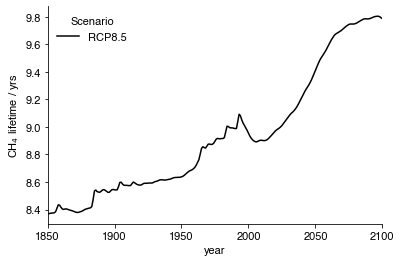

In [24]:
sn.lineplot(data=CH4_lifetime.loc[1850:2100],palette=['k'])
sn.despine()
plt.xlabel('year')
plt.ylabel('CH$_4$ lifetime / yrs')
plt.gca().ticklabel_format(style='plain')
plt.xlim(1850,2100)

[plt.savefig('../../docs/manuscript/figures/FigS2.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
''

In [25]:
# comparison with Holmes et al., 2013

## 2010 values:
print('Holmes 2010:',1/(1/120+1/150+1/200+1/11.2))
print('FaIRv2.0.0-alpha 2010:',CH4_lifetime.loc[2010].values[0],end='\n\n')

print('Holmes 2010-2100 change:',(1/120+1/150+1/200+1/11.2)/(1/120+1/150+1/200+1/(11.2*1.129)))
print('FaIRv2.0.0-alpha 2010-2100 change:',(CH4_lifetime.loc[2100]/CH4_lifetime.loc[2010]).values[0])

Holmes 2010: 9.15032679738562
FaIRv2.0.0-alpha 2010: 8.902796846929547

Holmes 2010-2100 change: 1.102961458892039
FaIRv2.0.0-alpha 2010-2100 change: 1.0991068995747098


# Supplement II. FaIRv2.0.0 additivity
Very brief test of how linear FaIR actually is. Non-linearity in FaIR only arises from the CO2 & CH4 cycles. The climate response of FaIR is linear in forcing. Here we test the linearity over history by carrying out several CO2 / CH4 pulse response experiments.

In [26]:
# default_SSP_run = run_FaIR(emissions_in=SSP_emms,forcing_in=SSP_forc)

base_emms = RCMIP_to_FaIR_input_emms('ssp245').interpolate().loc[1750:2500]
rebase_species = ['so2','nox','co','nmvoc','bc','nh3','oc','nox_avi','methyl_bromide','methyl_chloride','chcl3','ch2cl2']
base_emms.loc[:,rebase_species] -= base_emms.loc[1750,rebase_species]
base_emms = pd.concat([base_emms],axis=1,keys=['ssp245'])

experiments = []

# scale methane by 28 (GWP100) for closer comparison
pulse_scaling = dict(carbon_dioxide=12/44,methane=1000/28)

for species in ['carbon_dioxide','methane']:
    for pulse_size in [0]+list(np.arange(0.01,0.1,0.01))+list(np.arange(0.1,1,0.1))+list(np.arange(1,10,1))+list(np.arange(10,100,10))+list(np.arange(100,1001,100)):
        experiment = base_emms.copy()
        experiment.loc[2019,('ssp245',species)] += pulse_size*pulse_scaling[species]
        experiments += [experiment.rename(dict(ssp245=species+'_'+str(pulse_size)),axis=1,level=0)]
        
experiments = pd.concat(experiments,axis=1)

In [27]:
pulse_runs = run_FaIR(emissions_in=experiments,
                      forcing_in=pd.concat([get_RCMIP_forc('ssp245')]*experiments.columns.levels[0].size,axis=1,keys=experiments.columns.levels[0]))

Integrating 94 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|o3', 'cfc114', 'cfc114|o3', 'cfc115', 'cfc115|o3', 'cfc11|o3', 'cfc12', 'cfc12|o3', 'ch2cl2', 'ch2cl2|o3', 'ch3ccl3', 'ch3ccl3|o3', 'chcl3', 'chcl3|o3', 'co', 'co|o3', 'halon1202', 'halon1202|o3', 'halon1211', 'halon1211|o3', 'halon1301', 'halon1301|o3', 'halon2402', 'halon2402|o3', 'hcfc141b', 'hcfc141b|o3', 'hcfc142b', 'hcfc142b|o3', 'hcfc22', 'hcfc22|o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|o3', 'methyl_bromide', 'methyl_bromide|o3', 'methyl_chloride', 'methyl_chloride|o3', 'nf3', 'nh3', 'nitrous_oxide', 'nitrous_oxide|o3', 'nmvoc', 'nmvoc|o3', 'nox', 'nox_avi

100%|██████████| 750/750 [00:01<00:00, 729.12 timestep/s]


### nonlinearities in terms of scaled anomalies

In [28]:
## compute the pulse experiment anomalies relative to the baseline
pulse_temp_anomalies = (pulse_runs['T'] - pulse_runs['T'].carbon_dioxide_0.values)
pulse_temp_anomalies.columns = pd.MultiIndex.from_tuples([(x[:14],float(x[15:])) if x[0]=='c' else (x[:7],float(x[8:])) for x in pulse_temp_anomalies.columns.levels[0]])
pulse_temp_anomalies = pulse_temp_anomalies.drop(0,axis=1,level=1)

pulse_temp_anomalies_scaled = pulse_temp_anomalies.apply(lambda x: x*1000/x.name[1])

CO2_RF_anomalies = (pulse_runs['RF'].xs('carbon_dioxide',axis=1,level=2) - pulse_runs['RF'].xs('carbon_dioxide',axis=1,level=2).carbon_dioxide_0.values)
CO2_RF_anomalies.columns = pd.MultiIndex.from_tuples([(x[:14],float(x[15:])) if x[0]=='c' else (x[:7],float(x[8:])) for x in CO2_RF_anomalies.columns.levels[0]])
CO2_RF_anomalies = CO2_RF_anomalies.drop(0,axis=1,level=1)

CO2_RF_anomalies_scaled = CO2_RF_anomalies.apply(lambda x: x*1000/x.name[1])

CH4_RF_anomalies = (pulse_runs['RF'].xs('methane',axis=1,level=2) - pulse_runs['RF'].xs('methane',axis=1,level=2).carbon_dioxide_0.values)
CH4_RF_anomalies.columns = pd.MultiIndex.from_tuples([(x[:14],float(x[15:])) if x[0]=='c' else (x[:7],float(x[8:])) for x in CH4_RF_anomalies.columns.levels[0]])
CH4_RF_anomalies = CH4_RF_anomalies.drop(0,axis=1,level=1)

CH4_RF_anomalies_scaled = CH4_RF_anomalies.apply(lambda x: x*1000/x.name[1])

CO2_C_anomalies = (pulse_runs['C'].xs('carbon_dioxide',axis=1,level=2) - pulse_runs['C'].xs('carbon_dioxide',axis=1,level=2).carbon_dioxide_0.values)
CO2_C_anomalies.columns = pd.MultiIndex.from_tuples([(x[:14],float(x[15:])) if x[0]=='c' else (x[:7],float(x[8:])) for x in CO2_C_anomalies.columns.levels[0]])
CO2_C_anomalies = CO2_C_anomalies.drop(0,axis=1,level=1)

CO2_C_anomalies_scaled = CO2_C_anomalies.apply(lambda x: x*1000/x.name[1])

CH4_C_anomalies = (pulse_runs['C'].xs('methane',axis=1,level=2) - pulse_runs['C'].xs('methane',axis=1,level=2).carbon_dioxide_0.values)
CH4_C_anomalies.columns = pd.MultiIndex.from_tuples([(x[:14],float(x[15:])) if x[0]=='c' else (x[:7],float(x[8:])) for x in CH4_C_anomalies.columns.levels[0]])
CH4_C_anomalies = CH4_C_anomalies.drop(0,axis=1,level=1)

CH4_C_anomalies_scaled = CH4_C_anomalies.apply(lambda x: x*1000/x.name[1])

CO2_alph_anomalies = pulse_runs['alpha'].xs('carbon_dioxide',axis=1,level=2).sub(pulse_runs['alpha'].xs('carbon_dioxide',axis=1,level=2).carbon_dioxide_0,axis=0)
CO2_alph_anomalies.columns = pd.MultiIndex.from_tuples([(x[:14],float(x[15:])) if x[0]=='c' else (x[:7],float(x[8:])) for x in CO2_alph_anomalies.columns.levels[0]])
CO2_alph_anomalies = CO2_alph_anomalies.drop(0,axis=1,level=1)

CO2_alph_anomalies_scaled = CO2_alph_anomalies.apply(lambda x: x*1000/x.name[1])

CH4_alph_anomalies = pulse_runs['alpha'].xs('methane',axis=1,level=2).sub(pulse_runs['alpha'].xs('methane',axis=1,level=2).carbon_dioxide_0,axis=0)
CH4_alph_anomalies.columns = pd.MultiIndex.from_tuples([(x[:14],float(x[15:])) if x[0]=='c' else (x[:7],float(x[8:])) for x in CH4_alph_anomalies.columns.levels[0]])
CH4_alph_anomalies = CH4_alph_anomalies.drop(0,axis=1,level=1)

CH4_alph_anomalies_scaled = CH4_alph_anomalies.apply(lambda x: x*1000/x.name[1])

anomalies = pd.concat([pulse_temp_anomalies_scaled,
                       CO2_RF_anomalies_scaled,
                       CH4_RF_anomalies_scaled,
                       CO2_C_anomalies_scaled,
                       CH4_C_anomalies_scaled,
                       CO2_alph_anomalies_scaled,
                       CH4_alph_anomalies_scaled],
                       axis=1,
                       keys=['T',r'RF$_{\mathrm{CO}_2}$',r'RF$_{\mathrm{CH}_4}$',r'C$_{\mathrm{CO}_2}$',r'C$_{\mathrm{CH}_4}$',r'$\alpha_{\mathrm{CO}_2}$',r'$\alpha_{\mathrm{CH}_4}$'],
                       names=['variable']).rename(dict(carbon_dioxide='CO$_2$',methane='CH$_4$'),axis=1,level=1).loc[2020:].sort_index(axis=1).stack(level=[0,1,2]).reset_index().rename({'level_0':'time','level_2':'pulse_type','level_3':'pulse_size',0:'value'},axis=1)

anomalies.time -= 2019

# set relative to small pulse limit
## comment out if absolute anomalies (ie. relative to reference) desired
pulse_temp_anomalies_scaled = pulse_temp_anomalies_scaled.apply(lambda x: x-pulse_temp_anomalies_scaled.loc[:,(x.name[0],0.01)])
CO2_RF_anomalies_scaled = CO2_RF_anomalies_scaled.apply(lambda x: x-CO2_RF_anomalies_scaled.loc[:,(x.name[0],0.01)])
CH4_RF_anomalies_scaled = CH4_RF_anomalies_scaled.apply(lambda x: x-CH4_RF_anomalies_scaled.loc[:,(x.name[0],0.01)])
CO2_C_anomalies_scaled = CO2_C_anomalies_scaled.apply(lambda x: x-CO2_C_anomalies_scaled.loc[:,(x.name[0],0.01)])
CH4_C_anomalies_scaled = CH4_C_anomalies_scaled.apply(lambda x: x-CH4_C_anomalies_scaled.loc[:,(x.name[0],0.01)])
CO2_alph_anomalies_scaled = CO2_alph_anomalies_scaled.apply(lambda x: x-CO2_alph_anomalies_scaled.loc[:,(x.name[0],0.01)])
CH4_alph_anomalies_scaled = CH4_alph_anomalies_scaled.apply(lambda x: x-CH4_alph_anomalies_scaled.loc[:,(x.name[0],0.01)])

anomalies_rel = pd.concat([pulse_temp_anomalies_scaled,
                           CO2_RF_anomalies_scaled,
                           CH4_RF_anomalies_scaled,
                           CO2_C_anomalies_scaled,
                           CH4_C_anomalies_scaled,
                           CO2_alph_anomalies_scaled,
                           CH4_alph_anomalies_scaled],
                           axis=1,
                           keys=['T',r'RF$_{\mathrm{CO}_2}$',r'RF$_{\mathrm{CH}_4}$',r'C$_{\mathrm{CO}_2}$',r'C$_{\mathrm{CH}_4}$',r'$\alpha_{\mathrm{CO}_2}$',r'$\alpha_{\mathrm{CH}_4}$'],
                           names=['variable']).rename(dict(carbon_dioxide='CO$_2$ - relative',methane='CH$_4$ - relative'),axis=1,level=1).loc[2020:].sort_index(axis=1).stack(level=[0,1,2]).reset_index().rename({'level_0':'time','level_2':'pulse_type','level_3':'pulse_size',0:'value'},axis=1)

anomalies_rel.time -= 2019

In [29]:
plot_df = pd.concat([anomalies,anomalies_rel])
plot_df.head()

,time,variable,pulse_type,pulse_size,value
0,1,$\alpha_{\mathrm{CH}_4}$,CH$_4$,0.01,1.394436
1,1,$\alpha_{\mathrm{CH}_4}$,CH$_4$,0.02,1.394445
2,1,$\alpha_{\mathrm{CH}_4}$,CH$_4$,0.03,1.394454
3,1,$\alpha_{\mathrm{CH}_4}$,CH$_4$,0.04,1.394463
4,1,$\alpha_{\mathrm{CH}_4}$,CH$_4$,0.05,1.394472


''

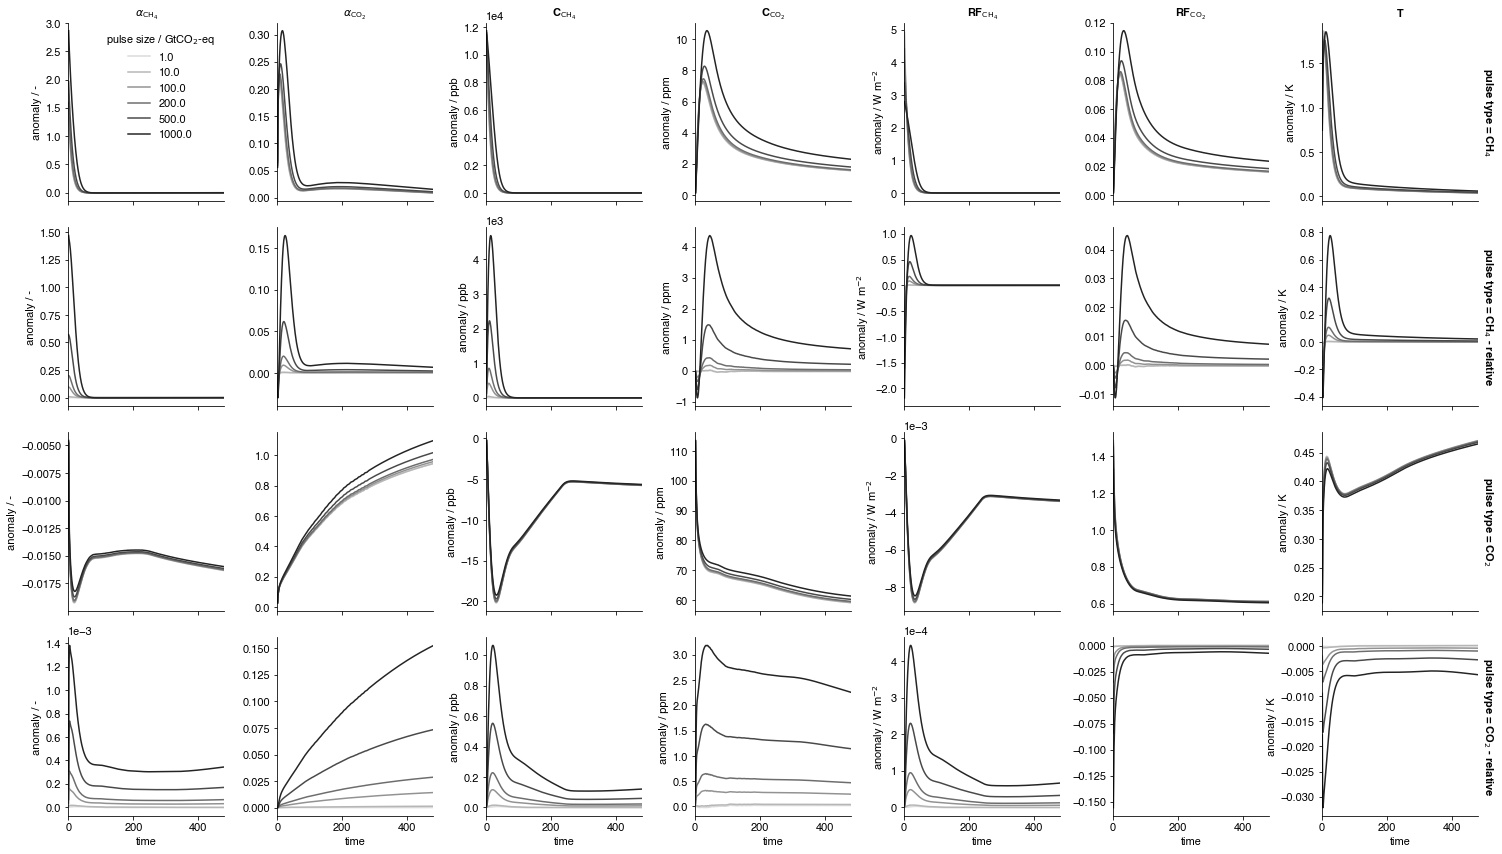

In [30]:
g=sn.FacetGrid(plot_df.query('pulse_size in [1,10,100,200,500,1000]').sort_values(['pulse_type','variable']),col='variable',row='pulse_type',hue='pulse_size',palette=[(x,x,x) for x in np.arange(0,1,1/7)[::-1]],margin_titles=True,sharey=False)
g.map(sn.lineplot,'time','value')

g.set_titles(col_template="{col_name}",row_template='pulse type = {row_name}',fontweight='bold').set(xlim=[0,480])
[a.set_ylabel('anomaly / ppb') for a in g.axes[:,2]]
[a.set_ylabel('anomaly / ppm') for a in g.axes[:,3]]
[a.set_ylabel('anomaly / W m$^{-2}$') for a in g.axes[:,4]]
[a.set_ylabel('anomaly / K') for a in g.axes[:,-1]]
[a.set_ylabel('anomaly / -') for a in g.axes[:,0]]

g.axes[0,0].legend(title='pulse size / GtCO$_2$-eq')

[plt.savefig('../../docs/manuscript/figures/FigS3.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
''

### measuring nonlinearities in a relative sense:
Marked out to prevent from running.

## measuring extent of nonlinearity as anomalies relative to 1000 GtC-eq pulse, normalised by 1000 GtC-eq pulse anomaly
CO2_T_nonlin = pulse_temp_anomalies_scaled.loc[2020:,'carbon_dioxide'].sub(pulse_temp_anomalies_scaled.loc[2020:,('carbon_dioxide',1000)],axis=0).div(pulse_temp_anomalies_scaled.loc[2020:,('carbon_dioxide',1000)],axis=0)
CH4_T_nonlin = pulse_temp_anomalies_scaled.loc[2020:,'methane'].sub(pulse_temp_anomalies_scaled.loc[2020:,('methane',1000)],axis=0).div(pulse_temp_anomalies_scaled.loc[2020:,('methane',1000)],axis=0)

CO2_CO2_RF_nonlin = CO2_RF_anomalies_scaled.loc[2020:,'carbon_dioxide'].sub(CO2_RF_anomalies_scaled.loc[2020:,('carbon_dioxide',1000)],axis=0).div(CO2_RF_anomalies_scaled.loc[2020:,('carbon_dioxide',1000)],axis=0)
CO2_CH4_RF_nonlin = CO2_RF_anomalies_scaled.loc[2020:,'methane'].sub(CO2_RF_anomalies_scaled.loc[2020:,('methane',1000)],axis=0).div(CO2_RF_anomalies_scaled.loc[2020:,('methane',1000)],axis=0)

CH4_CO2_RF_nonlin = CH4_RF_anomalies_scaled.loc[2020:,'carbon_dioxide'].sub(CH4_RF_anomalies_scaled.loc[2020:,('carbon_dioxide',1000)],axis=0).div(CH4_RF_anomalies_scaled.loc[2020:,('carbon_dioxide',1000)],axis=0)
CH4_CH4_RF_nonlin = CH4_RF_anomalies_scaled.loc[2020:,'methane'].sub(CH4_RF_anomalies_scaled.loc[2020:,('methane',1000)],axis=0).div(CH4_RF_anomalies_scaled.loc[2020:,('methane',1000)],axis=0)

CO2_CO2_C_nonlin = CO2_C_anomalies_scaled.loc[2020:,'carbon_dioxide'].sub(CO2_C_anomalies_scaled.loc[2020:,('carbon_dioxide',1000)],axis=0).div(CO2_C_anomalies_scaled.loc[2020:,('carbon_dioxide',1000)],axis=0)
CO2_CH4_C_nonlin = CO2_C_anomalies_scaled.loc[2020:,'methane'].sub(CO2_C_anomalies_scaled.loc[2020:,('methane',1000)],axis=0).div(CO2_C_anomalies_scaled.loc[2020:,('methane',1000)],axis=0)

CH4_CO2_C_nonlin = CH4_C_anomalies_scaled.loc[2020:,'carbon_dioxide'].sub(CH4_C_anomalies_scaled.loc[2020:,('carbon_dioxide',1000)],axis=0).div(CH4_C_anomalies_scaled.loc[2020:,('carbon_dioxide',1000)],axis=0)
CH4_CH4_C_nonlin = CH4_C_anomalies_scaled.loc[2020:,'methane'].sub(CH4_C_anomalies_scaled.loc[2020:,('methane',1000)],axis=0).div(CH4_C_anomalies_scaled.loc[2020:,('methane',1000)],axis=0)

CO2_CO2_alph_nonlin = CO2_alph_anomalies_scaled.loc[2020:,'carbon_dioxide'].sub(CO2_alph_anomalies_scaled.loc[2020:,('carbon_dioxide',1000)],axis=0).div(CO2_alph_anomalies_scaled.loc[2020:,('carbon_dioxide',1000)],axis=0)
CO2_CH4_alph_nonlin = CO2_alph_anomalies_scaled.loc[2020:,'methane'].sub(CO2_alph_anomalies_scaled.loc[2020:,('methane',1000)],axis=0).div(CO2_alph_anomalies_scaled.loc[2020:,('methane',1000)],axis=0)

CH4_CO2_alph_nonlin = CH4_alph_anomalies_scaled.loc[2020:,'carbon_dioxide'].sub(CH4_alph_anomalies_scaled.loc[2020:,('carbon_dioxide',1000)],axis=0).div(CH4_alph_anomalies_scaled.loc[2020:,('carbon_dioxide',1000)],axis=0)
CH4_CH4_alph_nonlin = CH4_alph_anomalies_scaled.loc[2020:,'methane'].sub(CH4_alph_anomalies_scaled.loc[2020:,('methane',1000)],axis=0).div(CH4_alph_anomalies_scaled.loc[2020:,('methane',1000)],axis=0)

nonlinearities = pd.concat([pd.concat([CO2_T_nonlin,CH4_T_nonlin],axis=1,keys=['CO2','CH4'],names=['pulse_type']),
                            pd.concat([CO2_CO2_RF_nonlin,CO2_CH4_RF_nonlin],axis=1,keys=['CO2','CH4'],names=['pulse_type']),
                            pd.concat([CH4_CO2_RF_nonlin,CH4_CO2_RF_nonlin],axis=1,keys=['CO2','CH4'],names=['pulse_type']),
                            pd.concat([CO2_CO2_C_nonlin,CO2_CH4_C_nonlin],axis=1,keys=['CO2','CH4'],names=['pulse_type']),
                            pd.concat([CH4_CO2_C_nonlin,CH4_CH4_C_nonlin],axis=1,keys=['CO2','CH4'],names=['pulse_type']),
                            pd.concat([CO2_CO2_alph_nonlin,CO2_CH4_alph_nonlin],axis=1,keys=['CO2','CH4'],names=['pulse_type']),
                            pd.concat([CH4_CO2_alph_nonlin,CH4_CH4_alph_nonlin],axis=1,keys=['CO2','CH4'],names=['pulse_type'])],
                           axis=1,
                           keys=['T','RF$_{\text{CO}_2}$','RF$_{\text{CH}_4}$','C$_{\text{CO}_2}$','C$_{\text{CH}_4}$','$\alpha_{\text{CO}_2}$','$\alpha_{\text{CH}_4}$'],
                           names=['variable']).sort_index(axis=1).stack(level=[0,1,2]).reset_index().rename({'level_0':'time','level_3':'pulse_size',0:'value'},axis=1)

nonlinearities.time -= 2019

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

class SymPowerNorm(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, order=1, clip=False):
        self.order = order
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [abs(self.vmin) / self.vmin * abs(self.vmin)**self.order , abs(self.vmax) / self.vmax * abs(self.vmax)**self.order], [0,1]
        return np.ma.masked_array(np.interp(abs(value) / value * abs(value)**self.order, x, y))

def mapplot(x,y,z,**kwargs):
    data = pd.concat([x,y,z],axis=1).set_index(['time','pulse_size']).unstack().droplevel(0,axis=1)
    norm=matplotlib.colors.Normalize(vmin=-0.5,vmax=0.5)#SymPowerNorm(order=1,vmin=-0.5,vmax=0.5)
    plt.pcolormesh(data.index,data.columns,data.values.T,shading='auto',norm=norm,cmap='RdBu_r')

g=sn.FacetGrid(nonlinearities,col='variable',row='pulse_type',margin_titles=True,despine=False,gridspec_kws=dict(hspace=0.1,wspace=0.1))
g.map(mapplot,'time','pulse_size','value')

g.set_titles(col_template="{col_name}",row_template='pulse type = {row_name}',fontweight='bold')
g.set(yscale='log')
[a.set_ylabel('pulse size / GtC-eq') for a in g.axes[:,0]]
[a.set_xlabel('year') for a in g.axes[-1,:]]

axins = inset_axes(g.axes[-1,-1], width="5%",height="100%",loc='lower left',bbox_to_anchor=(1.2, 0.55, 1, 1),bbox_transform=g.axes[-1,-1].transAxes,borderpad=0)
plt.colorbar(cax=axins,extend='both')